In [6]:
import torch
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import bitsandbytes.functional as F


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /opt/conda/lib/python3.7/site-packages/bitsandbytes/libbitsandbytes_cuda110.so
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /opt/conda/lib/python3.7/site-packages/bitsandbytes/libbitsandbytes_cuda110.so...


/opt/conda/lib/python3.7/site-packages/bitsandbytes/cuda_setup/main.py:145: UserWarning: /opt/conda did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)


In [7]:
orig_col_sizes = (16, 16, 16, 63, 32, 76, 16)

In [8]:
def read_last_n_chars(file_path, n):
    last_chars_list = []

    with open(file_path, 'r') as file:
        for line in file:
            last_chars = line.strip()[-n:]
            last_chars_list.append(last_chars)

    return last_chars_list

# Example usage:
start_path = '/home/sebeliassen/Exact-main/mem_speed_bench/simulated_act/'
file_path = '/home/sebeliassen/Exact-main/mem_speed_bench/simulated_act/order.txt'
tensor_names = read_last_n_chars(file_path, 16)[2:][::-1]

In [9]:
def generate_activation_stack(dataset, layer):
    start_path = '/home/sebeliassen/Exact-main/mem_speed_bench/simulated_act/'
    file_path = '/home/sebeliassen/Exact-main/mem_speed_bench/simulated_act/order.txt'
    tensor_names = read_last_n_chars(file_path, 16)[2:][::-1]

    if dataset == 'arxiv':
        idxs = np.r_[np.arange(15), np.arange(35, 50)]
        max_layer = 3
    elif dataset == 'flickr':
        idxs = np.r_[np.arange(15, 25), np.arange(50, 60)]
        max_layer = 2
    elif dataset == 'reddit':
        idxs = np.r_[np.arange(25, 35), np.arange(60, 70)]
        max_layer = 2
    else:
        raise Exception("Only datasets available are arxiv, flickr and reddit")
    
    idxs = idxs[layer::max_layer]
    tensors = [torch.load(start_path + tensor_names[i]) for i in idxs]
    return torch.stack(tensors, dim=0)

In [10]:
def normalize_and_reshape(input, col_size=0, perc=0):
    col_size = col_size
    col_size = max(col_size, input.size(-1))

    # Reshape input and cut off rows to fit the desired shape
    elements = input.numel()
    remaining_elements = elements % col_size
    main_part_rows = (elements - remaining_elements) // input.size(1)

    input = input[:main_part_rows].view(-1, col_size)

    # Row-wise normalization into the range [0, 3]
    min_vals, _ = torch.min(input, dim=1, keepdim=True)
    max_vals, _ = torch.max(input, dim=1, keepdim=True)
    input = (input - min_vals) * (3 / (max_vals - min_vals + 1e-8))

    # Clamp tensor values between perc percentile and 1-perc percentile
    if perc != 0:
        lo, hi = F.estimate_quantiles(input, offset=perc, num_quantiles=2)
        input = torch.clamp(input, min=lo, max=hi)

    # Flatten the tensor
    input = input.flatten()

    return input

In [11]:
def q_plot_act(acts, dist, save_file=True, normalize=True, ignore_boundaries=False, title="", dist_str="", scale=0.86):
    n_runs = acts.size(0)

    acts = acts.view(n_runs, -1)
    means = torch.mean(acts, axis=1, keepdims=True)
    stds = torch.std(acts, axis=1, keepdims=True)

    # if normalize:
    #     acts = (acts - means) / (stds)
    acts = torch.sort(acts, dim=-1)[0]
    acts = acts[:, ::7].cpu().numpy()

    observed_quantiles = acts
    observed_mean = np.mean(observed_quantiles, axis=0)
    observed_std = np.std(observed_quantiles, axis=0)

    clip_dist = False

    if isinstance(dist, str) and 'clipnorm' in dist:
        dist, quantile_den = 'clipnorm', int(dist.split('_')[-1])
    if dist == "clipnorm":
        dist = stats.norm
        clip_dist = True
        # Parameters
        mean = 1.5
        target_quantile = 1/quantile_den

        # Calculate the z-score
        z_score = stats.norm.ppf(target_quantile)

        # Calculate the standard deviation
        scale = (0 - mean) / z_score
        fit_params = (mean, scale)
    else:
      fit_params = dist.fit(observed_mean)  

    theoretical_quantiles = stats.probplot(observed_mean, dist=dist(*fit_params), fit=False)[0]

    if clip_dist:
        theoretical_quantiles = np.clip(theoretical_quantiles, 0, 3)

    if ignore_boundaries:
        obs_min = observed_mean.min()
        obs_max = observed_mean.max()
        obs_range = obs_max - obs_min

        less_mask = (observed_mean > observed_mean.min() + obs_range * 0.01)
        greater_mask = (observed_mean < observed_mean.max() - obs_range * 0.01)
        mask = less_mask & greater_mask

        observed_mean = observed_mean[mask]
        observed_std = observed_std[mask]
        theoretical_quantiles = theoretical_quantiles[mask]


    # Calculate the 95% confidence interval
    alpha = 0.05  # 100 - 95 = 5%, so alpha = 0.05
    dof = n_runs - 1  # degrees of freedom
    t_score = stats.t.ppf(1 - alpha / 2, dof)
    observed_ci = t_score * (observed_std / np.sqrt(n_runs))
    r_value, _ = stats.pearsonr(theoretical_quantiles, observed_mean)

    fig, (ax1, ax2) = plt.subplots(2, 1, dpi=300, figsize=(6, 9))

    # Plot the mean line
    ax1.plot(theoretical_quantiles, observed_mean, color='red', label='Mean')

    # Add shaded error bars (mean ± 1 SD)
    ax1.fill_between(theoretical_quantiles, observed_mean - observed_ci, observed_mean + observed_ci, color='red', alpha=0.2, label='95% confidence')

    # Plot the 45-degree line for an ideal normal distribution
    math_str = r"\mathcal{" + dist_str + "}"
    if clip_dist:
        math_str += "_{1/" + str(quantile_den) + "}"
    math_str += "(" + ', '.join([f"{num:.2f}" for num in fit_params]) + ")"
    ax1.plot(theoretical_quantiles, theoretical_quantiles, linestyle=(0, (5, 5)), color='k',
            label=f'Ideal Distribution (${math_str}$)')

    ax1.set_xlabel('Theoretical Quantiles')
    ax1.set_ylabel('Observed Quantiles')

    ax1.legend()
    
    pre_title = 'QQ-plot'# — normalized row-wise'
    if ignore_boundaries:
        pre_title += " — ignore boundaries"


    # Sample N equally spaced indices along the red line
    scatter_indices = np.linspace(0, len(theoretical_quantiles) - 1, 100, dtype=int)

    # Plot the scatter points
    ax1.scatter(theoretical_quantiles[scatter_indices], observed_mean[scatter_indices], color='red', alpha=0.5, s=7, zorder=0)
    ax1.set_title(f'{pre_title}\n{title} (r-value: {r_value:.4f})')
    
    ax2.hist(observed_mean, bins=100, alpha=0.7, label='Observed Mean', density=True)
    ax2.hist(theoretical_quantiles, bins=100, alpha=0.7, label='Theoretical Quantiles', density=True)
    ax2.set_title('Superimposed Distributions')
    ax2.legend()
    print(r_value)

    if save_file:
        filename = ''.join(c if c.isalnum() or c.isspace() else '' for c in title).replace(' ', '_')
        plt.tight_layout()
        # "no_bound_" * ignore_boundaries + "norm_" + 
        fig_path = "no_bound_" * ignore_boundaries + "norm_" + filename + f'_{dist_str}_'
        plt.savefig(fig_path + '.png')
        plt.clf()

        with open(fig_path + '.txt', 'w') as f:
            f.write(f'r-value: {r_value}')
    else:
        plt.show()

## Are the activations themselves more gaussian or uniform?

In [ ]:
layer_tups = [('arxiv', 0), ('arxiv', 1), ('arxiv', 2), ('flickr', 0), ('flickr', 1), 
              ('reddit', 0), ('reddit', 1)]

for tup in layer_tups[-2:]:
    print(tup)

    acts = generate_activation_stack(*tup)
    q_plot_act(acts, stats.norm, save_file = False, dist_str='N',
               title=f'dataset: {tup[0]}, layer: {tup[1]}')
    q_plot_act(acts, dist=stats.uniform, save_file = False, dist_str='U',
               title=f'dataset: {tup[0]}, layer: {tup[1]}')

## Are the normalized activations distributions more gaussian or more uniform?

In [ ]:
layer_tups = [('arxiv', 0), ('arxiv', 1), ('arxiv', 2), ('flickr', 0), ('flickr', 1), 
              ('reddit', 0), ('reddit', 1)]

for iter_bool in (False, True):
    for col_idx, tup in enumerate(layer_tups):

        acts = generate_activation_stack(*tup)
        acts = torch.stack([normalize_and_reshape(run_acts) for run_acts in acts], 0)
        
        q_plot_act(acts, f"clipnorm_{orig_col_sizes[col_idx]}", save_file=False, ignore_boundaries=iter_bool,
                   title=f'dataset: {tup[0]}, layer: {tup[1]}', dist_str='CN')
        # q_plot_act(acts, stats.truncnorm, save_file=True, ignore_boundaries=iter_bool,
        #         title=f'dataset: {tup[0]}, layer: {tup[1]}', dist_str='TN')
        # q_plot_act(acts, stats.norm, save_file=False, ignore_boundaries=iter_bool,
        #         title=f'dataset: {tup[0]}, layer: {tup[1]}', dist_str='N')
        # q_plot_act(acts, dist=stats.uniform, save_file=False, ignore_boundaries=iter_bool,
        #         title=f'dataset: {tup[0]}, layer: {tup[1]}', dist_str='U')
    break

## Does changing col size make it more gaussian?

In [ ]:
layer_tups = [('arxiv', 0), ('arxiv', 1), ('arxiv', 2), ('flickr', 0), ('flickr', 1), 
              ('reddit', 0), ('reddit', 1)]

arxiv_col_sizes = (16, 32, 64, 128, 256, 512, 1024)
flickr_col_sizes_0 = (63, 126, 252, 504, 1008)
flickr_col_sizes_1 = (32, 64, 128, 256, 512, 1024)
reddit_col_sizes_0 = (76, 152, 304, 608, 1216)
reddit_col_sizes_1 = (16, 32, 64, 128, 256, 512, 1024)

for tup in layer_tups:
    curr_dataset = tup[0]
    curr_layer = tup[1]
    if curr_dataset == 'arxiv':
        curr_col_sizes = arxiv_col_sizes
    if curr_dataset == 'flickr':
        if curr_layer == 0:
            curr_col_sizes = flickr_col_sizes_0
        elif curr_layer == 1:
            curr_col_sizes = flickr_col_sizes_1
    if curr_dataset == 'reddit':
        if curr_layer == 0:
            curr_col_sizes = reddit_col_sizes_0
        elif curr_layer == 1:
            curr_col_sizes = reddit_col_sizes_1

    for col_size in curr_col_sizes:
        acts = generate_activation_stack(*tup)
        acts = torch.stack([normalize_and_reshape(run_acts, col_size=col_size) for run_acts in acts], 0)
        
        # q_plot_act(acts, stats.norm, save_file=True,
        #         title=f'dataset: {tup[0]}, layer: {tup[1]}, col_size: {col_size}', dist_str='N')
        # q_plot_act(acts, dist=stats.uniform, save_file=True,
        #         title=f'dataset: {tup[0]}, layer: {tup[1]}, col_size: {col_size}', dist_str='U')
        q_plot_act(acts, dist=f"clipnorm_{col_size}", save_file=True,
                   title=f'dataset: {tup[0]}, layer: {tup[1]}, col_size: {col_size}', dist_str='CN')

### Scatter-plot of the col_size r_values

In [12]:
def load_colsize_cn_r_values(filename):
    colsize_cn_r_values = []

    with open(filename, 'r') as file:
        for line in file:
            if 'colsize' in line and (('N' in line and 'TN' not in line) or 'U' in line):
                parts = line.strip().split(':')
                filename = parts[0].strip()
                r_value = float(parts[2].strip())
                colsize_cn_r_values.append((filename, r_value))

    return colsize_cn_r_values

def extract_layer_colsize_r_values(tuples):
    extracted_data = []

    for item in tuples:
        filename, r_value = item
        parts = filename.split('_')

        dataset = parts[2]
        layer = parts[4]
        colsize = parts[6]
        distribution = parts[7]

        layer_colsize_r_value = ((dataset, layer), int(colsize), round(np.log2(int(colsize))),
                                 r_value, distribution)
        extracted_data.append(layer_colsize_r_value)

    return extracted_data

In [13]:
tuple_list = load_colsize_cn_r_values("output.txt")
data = extract_layer_colsize_r_values(tuple_list)

In [177]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


def plot_clustered_col_data(data, dists, cluster=True):
    dataset_colors = {'arxiv': 'red', 'flickr': 'green', 'reddit': 'blue'}
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(12, 4))
    
    all_dataset_points = {}
    for curr_dist in dists:
        all_cluster_points = {}
        
        # Filter data for the current distribution
        filtered_data = [item for item in data if item[-1] == curr_dist]

        for (dataset, layer), col_size, cluster_idx, r_value, dist in filtered_data:
            all_cluster_points.setdefault(cluster_idx, []).append((col_size, r_value))
            all_dataset_points.setdefault(dataset, []).append((col_size, r_value))
        
        x_poss = []
        y_poss = []

        for cluster_idx, value in all_cluster_points.items():
            cluster_pos = np.mean(value, axis=0)

            x_poss.append(cluster_pos[0])
            y_poss.append(cluster_pos[1])
            
        x_poss = np.array(x_poss)
        y_poss = np.array(y_poss)
        poss_order = np.argsort(x_poss)

        ax1.plot(x_poss[poss_order], y_poss[poss_order], 
                 label=r'$\mathcal{' + curr_dist + r'}$')
        ax1.scatter(x_poss[poss_order], y_poss[poss_order], s=10)
        
        ax2.plot(x_poss[poss_order], y_poss[poss_order], 
                 label=r'$\mathcal{' + curr_dist + r'}$')
        ax2.scatter(x_poss[poss_order], y_poss[poss_order], s=10)

    for curr_dataset, dataset_points in all_dataset_points.items():
        ax1.scatter(*zip(*dataset_points), color=dataset_colors[curr_dataset], label=curr_dataset, s=5, alpha=0.3)
        ax2.scatter(*zip(*dataset_points), color=dataset_colors[curr_dataset], label=curr_dataset, s=5, alpha=0.3)

    ax1.set_xscale('log')
    ax2.set_xscale('log')

    for exp in np.arange(4.5, 10, 1):
        ax1.axvline(2 ** exp, color='gray', linestyle='dashed', alpha=0.5)
        ax2.axvline(2 ** exp, color='gray', linestyle='dashed', alpha=0.5)

    ax1.set_ylim(0.95, 1)
    ax2.set_ylim(0.99, 1)

    ax1.set_xlabel('block size')
    ax2.set_xlabel('block size')

    ax1.set_ylabel('r-value')
    ax2.set_ylabel('r-value')

    # Custom legend
    legend_elements = []
    legend_elements.extend([Line2D([0], [0], color='C' + str(i), lw=2, label=r'$\mathcal{' + dist + r'}$') for i, dist in enumerate(dists)])
    legend_elements.append(Patch(facecolor='none', edgecolor='none', label='-' * 8))  # Separator line
    legend_elements.extend([Patch(facecolor=dataset_colors[dataset], edgecolor='none', label=dataset) for dataset in dataset_colors.keys()])

    ax1.legend(handles=legend_elements, loc='lower left')

    plt.suptitle('Clustered r-values for the distributions at varying block sizes')
    plt.savefig('cluster_r_values.png', dpi=300)

    plt.show()


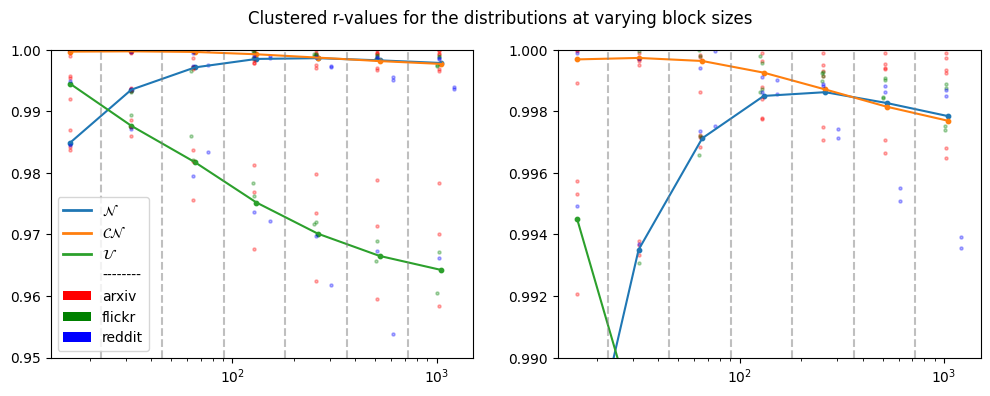

In [178]:
plot_clustered_col_data(data, ['N', 'CN', 'U'])

In [45]:
data[0]

(('arxiv', '0'), 1024, 10, 0.9998848570348878, 'CN')